The aim of this is to be able to accurately detect human faces (if any) in a picture and to localise the face with a fitting bounding box.

With awarenesss of already trained models that can perform such task in just a few lines of code, such as the face detetcion model from OpenCV, I will be training a new model instead using the images dataset attached to this notebook. I am treating this as a standard object detection task rather than specifically focusing on facial detection.

The dataset contains images of people, dimensions of the images, and the bounding box coordinates of people's faces present in each picture.

Lets get started.

In [2]:
# defining a few configurations

import torch

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CLASSES = ['background', 'Face']
NUM_CLASSES = 2

In [3]:
# check if cuda (GPU) is available

torch.cuda.is_available()

False

In [4]:
import os
import kaggle

dataset_path = 'Datasets/sbaghbidi/human-faces-object-detection'
file_name = 'human-faces-object-detection'
zip_path = os.path.join(dataset_path, file_name + '.zip')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    kaggle.api.dataset_download_files('sbaghbidi/human-faces-object-detection', path=dataset_path, unzip=True)
else:
    print("Zestaw danych został już pobrany")

Zestaw danych został już pobrany


In [5]:
# Split dataset into train, validation, and train sets

import pandas as pd
import shutil
import os

def train_valid_test_split(faces_csv=None, split=0.15):
    all_df = pd.read_csv(faces_csv)     
    
    # sample out 500 images
    all_df = all_df.sample(n=500, random_state=7)
    
    # Shuffle the CSV file rows.
    all_df.sample(frac=1)
    len_df = len(all_df)
    
    # Split into train/validation and test sets
    trainTest_split = int((1-split)*len_df)
    
    trainVal_df = all_df[:trainTest_split]
    test_df = all_df[trainTest_split:]
    
    # Further split train/validation set into train and validation sets
    lenTV_df = len(trainVal_df)
    
    trainVal_split = int((1-split)*lenTV_df)
    
    train_df = trainVal_df[:trainVal_split]
    valid_df = trainVal_df[trainVal_split:]
    
    return train_df, valid_df, test_df
    
train_df, valid_df, test_df = train_valid_test_split(faces_csv='./Datasets/sbaghbidi/human-faces-object-detection/faces.csv')

Above, we split the dataset into training, validation, and test sets.

But before that, we sample out only 500 entries in the dataset (of about 3000 total). This is surely small to train a whole CNN model on, as the 3000+ itself. However, because training an efficient CNN model from scratch requires a whole lot resources and tens of thousands to millions of images, we will be using pretrained model that has been trained on the COCO dataset - a benchmark dataset for most object detection tasks. 

We will perform transfer learning by fine tuning the model to fit our task so that the model can now accurately identify and localise objects in our custom dataset (that is not in the COCO dataset). This way, we can have a functional model from a dataset as small as ours.

In [6]:
import cv2
import numpy as np

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well

class Averager:
    """""
    this class keeps track of the training and validation loss values...
    and helps to get the average for each epoch as well
    """""
    
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [7]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

# Creating the dataset class

class Faces(Dataset):
    def __init__(self, dataset, width, height, dir_path="./Datasets/sbaghbidi/human-faces-object-detection/images"):
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.dataset = dataset
        
        # copy image names to list
        self.set_image_names = self.dataset['image_name'].tolist()
        
        # to ma byc uruchamiane na windows
        self.dir_path = Path(dir_path)
        self.image_paths = list(self.dir_path.glob("*.jpg"))
        self.all_images = [str(image_path.name) for image_path in self.image_paths]
        self.all_images.sort()

        
        # cut down to only images present in dataset
        self.images = []
        
        for i in self.set_image_names:
            for j in self.all_images:
                if i == j:
                    self.images.append(i)
        
    def __getitem__(self, idx):
        
        # capture the image name and the full image path
        image_name = self.images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # read the image
        image = cv2.imread(image_path)
        
        # convert BGR to RGB color format and resize
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # channel first transposing
        image_resized = np.transpose(image_resized, (2, 0, 1))
             
        boxes = []
        labels = []

        # Copy bounding box coordinates and image dimensions
        filtered_df = self.dataset.loc[self.dataset['image_name'] == image_name]
        
        for i in range(len(filtered_df)):

            # xmax = left corner x-coordinates
            xmin = int(filtered_df['x0'].iloc[i])
            # xmax = right corner x-coordinates
            xmax = int(filtered_df['x1'].iloc[i])
            # ymin = left corner y-coordinates
            ymin = int(filtered_df['y0'].iloc[i])
            # ymax = right corner y-coordinates
            ymax = int(filtered_df['y1'].iloc[i])

            image_width = int(filtered_df['width'].iloc[i])
            image_height = int(filtered_df['height'].iloc[i])

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
            labels.append(1) # 1 because there is only one class
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # crowd instances
        if boxes.shape[0] > 1:
            iscrowd = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
            
        # label to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        return image_resized, target
    
    def __len__(self):
        return len(self.set_image_names)

The code above is a class that iterates over each image in either of our train or validation set, performs a few operations, and returns the image and target (bounding box coordinates, object label, e.t.c.) components.

Below we will pass in the train and validation sets and store the returned components.

We also defined our data loaders below. These loaders will help load data in bacthes into the model during training and validation.

In [8]:
train_dataset = Faces(train_df, RESIZE_TO, RESIZE_TO)
valid_dataset = Faces(valid_df, RESIZE_TO, RESIZE_TO)

# defining train and validation sets data loaders

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 361
Number of validation samples: 64



At this point, our image and target components are ready, and we will preview a number of them below to confirm everything is as expected before moving on to traning a model on them.

In [9]:
print(valid_dataset.images)

['00002784.jpg', '00000902.jpg', '00000567.jpg', '00000642.jpg', '00000820.jpg', '00000525.jpg', '00003317.jpg', '00002385.jpg', '00001109.jpg', '00003344.jpg', '00000243.jpg', '00001195.jpg', '00002280.jpg', '00000699.jpg', '00000503.jpg', '00003353.jpg', '00001693.jpg', '00000965.jpg', '00001837.jpg', '00000617.jpg', '00000196.jpg', '00001223.jpg', '00000612.jpg', '00003404.jpg', '00002722.jpg', '00001615.jpg', '00002669.jpg', '00003317.jpg', '00003288.jpg', '00003358.jpg', '00002086.jpg', '00001542.jpg', '00002133.jpg', '00002375.jpg', '00002489.jpg', '00003402.jpg', '00000593.jpg', '00002229.jpg', '00001740.jpg', '00000605.jpg', '00002689.jpg', '00000377.jpg', '00003225.jpg', '00001407.jpg', '00000703.jpg', '00002628.jpg', '00000707.jpg', '00003517.jpg', '00000222.jpg', '00002674.jpg', '00000702.jpg', '00001410.jpg', '00002517.jpg', '00001904.jpg', '00002359.jpg', '00000592.jpg', '00001972.jpg', '00002885.jpg', '00000829.jpg', '00002183.jpg', '00000763.jpg', '00003304.jpg', '000027

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


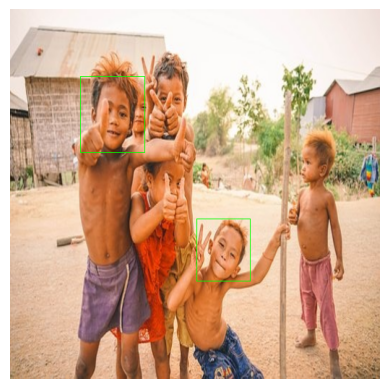

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


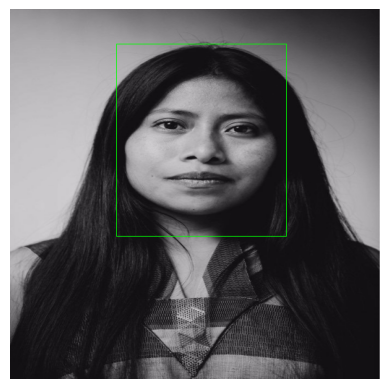

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


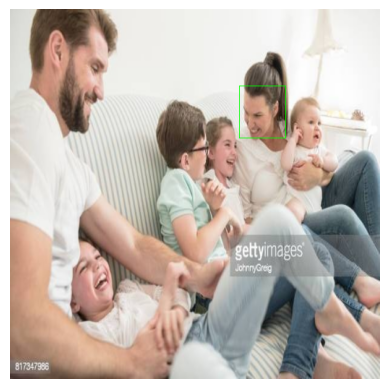

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


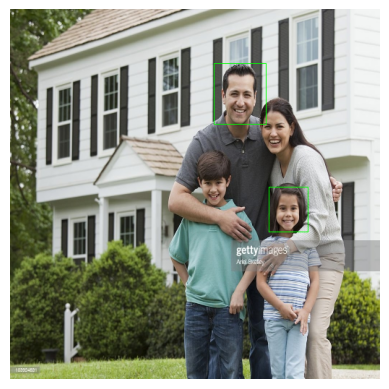

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


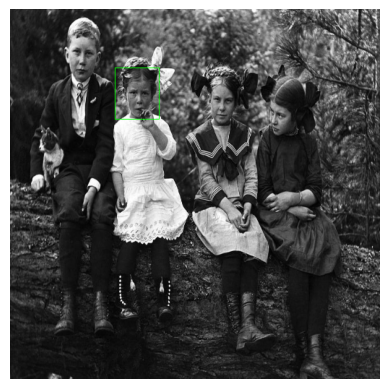

In [10]:
import matplotlib.pyplot as plt

# function to visualize sample

def visualize_sample(image, target):
    for box in target['boxes']:
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    visualize_sample(image, target)

Above is what the images in the dataset look like with the bounding boxes.

Normally, there are bounding box coordinates for each face (where there are more than one person) in almost all the images in the dataset. The reason some faces don't have here is because we have sampled only 500 from the entire dataset, as such, some bounding box coordinates wouldn't have made the sample set. This doesn't mean the dataset is bad though, it is just a subset of the entire dataset and still very much efficient to train with, as we will see later on.

**Defining the model**

The model that we will be using is the pretrained Faster RCNN with a Resnet 50 backbone. We will fine tune the box head predictor so the output matches the number of classes in our custom dataset, which is 2. The first class is reserved for the background and the the second class is our faces.

In [11]:
# defining model

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

Next, we will define functions for running training and validation iterations then begin the training process.

In [12]:
# function for running training iterations

def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(torch.from_numpy(image).to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [13]:
# function for running validation iterations

def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(torch.from_numpy(image).to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

We will be training our model for only 10 epochs.

After a number of tests, I have found out that the optimal number of epochs to use for this task is 10. The model tends to start overfitting at higher epochs. One may say this is due to the small dataset, however, even with a larger or augmented set, it tends to start overfitting at higher epochs.

A meaningful explanation as to why is that the model had at 10 epochs learned all it needed to know to be able to correctly perform the object detection task, such that more epochs on the data is no longer beneficiary.

As we will see during evaluation on the test set, the model after training for 10 epochs performs brilliantly.

In [14]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
import os

plt.style.use('ggplot')

NUM_EPOCHS = 1 # number of epochs to train for

# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(os.path.join(os.getcwd(), f"train_loss_{epoch+1}.png"))
        figure_2.savefig(os.path.join(os.getcwd(), f"valid_loss_{epoch+1}.png"))
        torch.save(model.state_dict(), os.path.join(os.getcwd(), f"model{epoch+1}.pth"))

train_ax.plot(train_loss, color='blue')
train_ax.set_xlabel('iterations')
train_ax.set_ylabel('train loss')

valid_ax.plot(val_loss, color='red')
valid_ax.set_xlabel('iterations')
valid_ax.set_ylabel('validation loss')
plt.show()


EPOCH 1 of 1
Training


  0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Testing trained model on 5 random images from the test set**

Test instances: 75


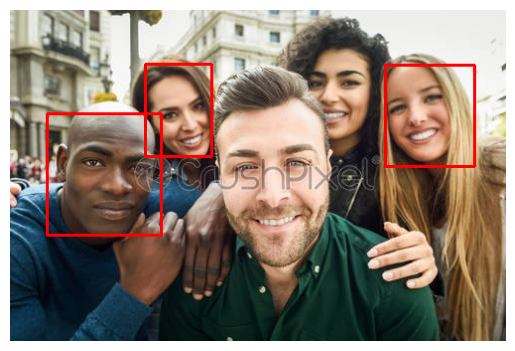

Image 10 done...
--------------------------------------------------


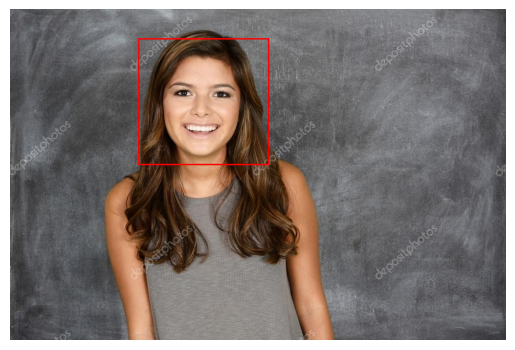

Image 42 done...
--------------------------------------------------


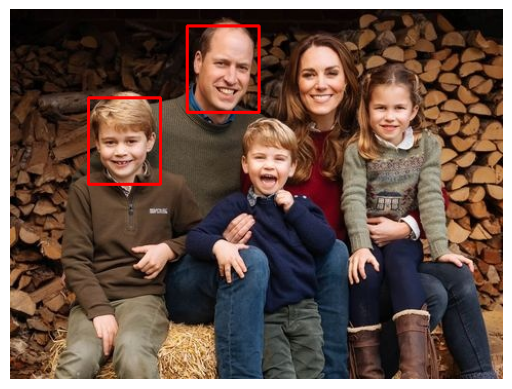

Image 47 done...
--------------------------------------------------


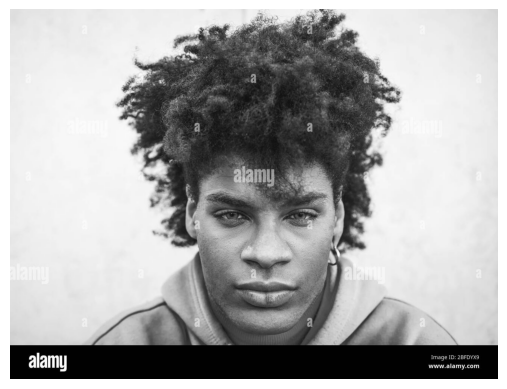

Image 44 done...
--------------------------------------------------


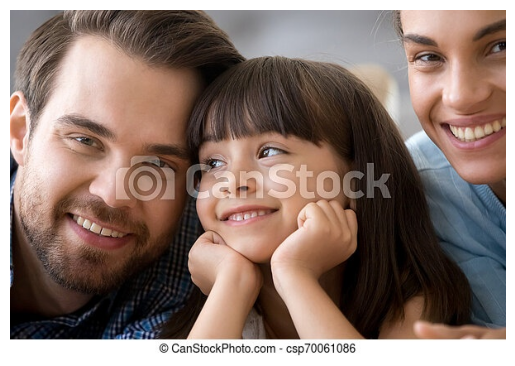

Image 54 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [29]:
# testing trained model on test set

import random
model.eval()

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

# copy image names to list
test_image_names = test_df['image_name'].tolist()

# get all the image names in sorted order
dir_path="./Datasets/sbaghbidi/human-faces-object-detection/images"
dir_path = Path(dir_path)
image_paths = list(dir_path.glob("*.jpg"))
all_images = [str(image_path.resolve()).split('\\')[-1] for image_path in image_paths]
all_images = sorted(all_images)

# get paths of only images present in dataset
test_images = []

for i in test_image_names:
    for j in all_images:
        if i == j:
            test_images.append(os.path.join(dir_path, i))
            

print(f"Test instances: {len(test_images)}")

for i in random.sample(range(len(test_images)), 5):
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        
        # draw the bounding boxes
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
        image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')

As we can see, even though we trained with only 500 samples and for only 10 epochs, the model does brilliant on new unseen images of people.

This is only a simple demonstration though; an ideal application of the model may require us to train with more data to enhance the model's effectiveness in detecting even more intricate faces.